Install necessary libraries `scipy` for scientific computing and `seaborn` for data visualization capabilities.Optuna for hyperparameter tuning

In [ ]:
# Install Required Libraries
!pip install scipy seaborn optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00


Mount Google Drive to access the data files stored there

In [ ]:
# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the required libraries. `numpy` for numerical operations, `scipy.io` for loading MATLAB files, `sklearn` for machine learning model creation, training, and evaluation, `matplotlib.pyplot` and `seaborn` for data visualization. Other libraries for ML architectures and for evaluating them

In [ ]:
# Import necessary libraries
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

Load the coherence data from a MATLAB (.mat) file stored in Google Drive. It contains the coherence matrices for Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD), and Healthy Controls (HC). Use `scipy.io.loadmat` to read the .mat file

In [ ]:
# Load the coherence data from .mat file
mat_file_path = '/content/drive/MyDrive/GNN_Approach/Data_files/Coherence.mat'
mat = scipy.io.loadmat(mat_file_path)
coherence_data = mat['Coherence'][0, 0]

Extract the Coherence data for different categories: Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD), and Healthy Controls (HC)

In [ ]:
# Extracting data in different categories (AZ, FTD, HC)
coherence_AZ_F = coherence_data['AZ']
coherence_FTD_F = coherence_data['FTD']
coherence_HC_F = coherence_data['HC']


Extract the data corresponding to the 3rd frequency band (index 2) and then reshape the extracted data

In [ ]:
# Extract the 3rd frequency band (index 2) and normalize the data
coherence_AZ = coherence_AZ_F[:, : , :].reshape(2346, 5, 36)
coherence_FTD = coherence_FTD_F[:, : , :].reshape(2346, 5, 23)
coherence_HC = coherence_HC_F[:, : , :].reshape(2346, 5, 29)

# Optional: To test whether the data is converted properly into numpy arrays
print(coherence_AZ.shape)
print(coherence_FTD.shape)
print(coherence_HC.shape)

(2346, 5, 36)
(2346, 5, 23)
(2346, 5, 29)


Create Feature mask with given P values for 3 Categories. Here you can give the P values to select the features which are used to masking the connectivity data

In [ ]:

# Reshape data to (2346, 5, 36), (2346, 5, 29), (2346, 5, 23)
fm_data_az = coherence_AZ.reshape(2346, 5, 36)
fm_data_hc = coherence_HC.reshape(2346, 5, 29)
fm_data_ftd = coherence_FTD.reshape(2346, 5, 23)

alpha_az_hc = 0.01
alpha_ftd_hc = 0.01
alpha_az_ftd = 0.06

p_values_az_hc = np.zeros((fm_data_az.shape[0], fm_data_az.shape[1]))
p_values_ftd_hc = np.zeros((fm_data_ftd.shape[0], fm_data_ftd.shape[1]))
p_values_az_ftd = np.zeros((fm_data_az.shape[0], fm_data_az.shape[1]))

# Calculate p-values for AZ vs HC
for i in range(fm_data_az.shape[0]):
    for j in range(fm_data_az.shape[1]):
        _, p_value = ttest_ind(fm_data_az[i, j, :], fm_data_hc[i, j, :], equal_var=False) # welch's t test (Varient of Independent two sample t test)
        p_values_az_hc[i, j] = p_value

# Calculate p-values for FTD vs HC
for i in range(fm_data_ftd.shape[0]):
    for j in range(fm_data_ftd.shape[1]):
        _, p_value = ttest_ind(fm_data_ftd[i, j, :], fm_data_hc[i, j, :], equal_var=False)
        p_values_ftd_hc[i, j] = p_value

# Calculate p-values for AZ vs FTD
for i in range(fm_data_az.shape[0]):
    for j in range(fm_data_az.shape[1]):
        _, p_value = ttest_ind(fm_data_az[i, j, :], fm_data_ftd[i, j, :], equal_var=False)
        p_values_az_ftd[i, j] = p_value

# Create boolean masks
mask_az_hc = (p_values_az_hc < alpha_az_hc).astype(int).reshape(2346, 5, 1)
mask_ftd_hc = (p_values_ftd_hc < alpha_ftd_hc).astype(int).reshape(2346, 5, 1)
mask_az_ftd = (p_values_az_ftd < alpha_az_ftd).astype(int).reshape(2346, 5, 1)

print("Shapes of masks:")
print(mask_az_hc.shape)
print(mask_ftd_hc.shape)
print(mask_az_ftd.shape)

def calculate_significant_percentage(feature_mask):
    total_features = feature_mask.size
    significant_features = np.sum(feature_mask)
    percentage = (significant_features / total_features) * 100
    return percentage


# Calculate and print percentage of significant features for individual masks
percentage_significant_AZ_HC = calculate_significant_percentage(mask_az_hc)
print("AZ_HC Feature mask):")
print(mask_az_hc.shape)
print(f"Percentage of significant features AZ vs HC : {percentage_significant_AZ_HC:.2f}%")

percentage_significant_FTD_HC = calculate_significant_percentage(mask_ftd_hc)
print("FTD_HC Feature mask):")
print(mask_ftd_hc.shape)
print(f"Percentage of significant features FTD vs HC : {percentage_significant_FTD_HC:.2f}%")

percentage_significant_AZ_FTD = calculate_significant_percentage(mask_az_ftd)
print("AZ_FTD Feature mask):")
print(mask_az_ftd.shape)
print(f"Percentage of significant features AZ vs FTD  : {percentage_significant_AZ_FTD:.2f}%")

# Create combined feature mask
combined_feature_mask = ((mask_az_hc + mask_ftd_hc + mask_az_ftd) > 0).astype(int)

# Calculate and print percentage of significant features for combined mask
percentage_significant_combined = calculate_significant_percentage(combined_feature_mask)
print("Combined Feature mask:")
print(combined_feature_mask.shape)
print(f"Percentage of significant features in combined mask: {percentage_significant_combined:.2f}%")


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Shapes of masks:
(2346, 5, 1)
(2346, 5, 1)
(2346, 5, 1)
AZ_HC Feature mask):
(2346, 5, 1)
Percentage of significant features AZ vs HC : 11.24%
FTD_HC Feature mask):
(2346, 5, 1)
Percentage of significant features FTD vs HC : 4.68%
AZ_FTD Feature mask):
(2346, 5, 1)
Percentage of significant features AZ vs FTD  : 5.46%
Combined Feature mask:
(2346, 5, 1)
Percentage of significant features in combined mask: 16.76%


Band Filter for the above Features obtained with different P values. set the bands you dont want and make them into zero

In [ ]:
bands_to_zero = []

mask_az_hc[:, bands_to_zero, :] = 0
mask_ftd_hc[:, bands_to_zero, :] = 0
mask_az_ftd[:, bands_to_zero, :] = 0

# Create combined feature mask
combined_feature_mask = ((mask_az_hc + mask_ftd_hc + mask_az_ftd) > 0).astype(int)

# Calculate and print percentage of significant features for individual masks
percentage_significant_AZ_HC = calculate_significant_percentage(mask_az_hc)
print("AZ_HC Feature mask):")
print(mask_az_hc.shape)
print(f"Percentage of significant features AZ vs HC : {percentage_significant_AZ_HC:.2f}%")

percentage_significant_FTD_HC = calculate_significant_percentage(mask_ftd_hc)
print("FTD_HC Feature mask):")
print(mask_ftd_hc.shape)
print(f"Percentage of significant features FTD vs HC : {percentage_significant_FTD_HC:.2f}%")

percentage_significant_AZ_FTD = calculate_significant_percentage(mask_az_ftd)
print("AZ_FTD Feature mask):")
print(mask_az_ftd.shape)
print(f"Percentage of significant features AZ vs FTD  : {percentage_significant_AZ_FTD:.2f}%")

# Calculate and print percentage of significant features for combined mask
percentage_significant_combined = calculate_significant_percentage(combined_feature_mask)
print("Combined Feature mask:")
print(combined_feature_mask.shape)
print(f"Percentage of significant features in combined mask: {percentage_significant_combined:.2f}%")

AZ_HC Feature mask):
(2346, 5, 1)
Percentage of significant features AZ vs HC : 11.24%
FTD_HC Feature mask):
(2346, 5, 1)
Percentage of significant features FTD vs HC : 4.68%
AZ_FTD Feature mask):
(2346, 5, 1)
Percentage of significant features AZ vs FTD  : 4.50%
Combined Feature mask:
(2346, 5, 1)
Percentage of significant features in combined mask: 16.05%


Custom feature mask, Required feature indices needed to be inserted manually.

In [ ]:
# add a custom mask use this code part for customising that
custom_masks = [np.zeros(2346, dtype=int) for _ in range(5)]

# send the whole 3rd band
custom_masks[2] = np.ones(2346, dtype=int)  # Initialize custom_mask_band_3 with ones

# Indices to be set to 1 (example indices for each band)
indices_to_set = [
    [],  # Indices for custom_mask_band_1
    [],  # Indices for custom_mask_band_2
    [],  # Indices for custom_mask_band_3
    [], # Indices for custom_mask_band_4
    [] # Indices for custom_mask_band_5
]

# Set specific indices to 1 in each custom mask array
for i in range(5):
    custom_masks[i][indices_to_set[i]] = 1

# Initialize the combined feature mask
custom_combined_feature_mask = np.zeros((2346, 5, 1), dtype=int)

# Populate the combined feature mask using a loop
for i in range(5):
    custom_combined_feature_mask[:, i, 0] = custom_masks[i]

combined_feature_mask = custom_combined_feature_mask


def calculate_significant_percentage(feature_mask):
    total_features = feature_mask.size
    significant_features = np.sum(feature_mask)
    percentage = (significant_features / total_features) * 100
    return percentage

# Calculate and print percentage of significant features for combined mask
percentage_significant_combined = calculate_significant_percentage(combined_feature_mask)
print("Combined Feature mask:")
print(combined_feature_mask.shape)
print(f"Percentage of significant features in combined mask: {percentage_significant_combined:.2f}%")


Combined Feature mask:
(2346, 5, 1)
Percentage of significant features in combined mask: 20.00%


Importing feature mask which was obtained from the Statistical approach with different parameters ( Coherence Threshould, Overlap Threshold, Alpha, %Trial Presence )

In [ ]:
import scipy.io

# Load the coherence data from .mat file
mat_file_path = '/content/drive/MyDrive/GNN_Approach/COH_masks_F/coherence_mask_4_2.mat'
mat = scipy.io.loadmat(mat_file_path)

# Check the structure of the loaded .mat file
print(mat.keys())

# Extract the 'coherence_mask' variable
coherence_mask_from_struct = mat['coherence_mask']
print(coherence_mask_from_struct.shape)


dict_keys(['__header__', '__version__', '__globals__', 'CthInd', 'Np', 'OLthInd', 'alpha', 'coherence_mask'])
(2346, 5)


In [ ]:


##### Mask externally imported
imported_mask = coherence_mask_from_struct.reshape(2346, 5, 1)


bands_to_zero = []
imported_mask[:, bands_to_zero, :] = 0



custom_combined_feature_mask = imported_mask


# Print the combined feature mask
print(custom_combined_feature_mask.shape)

combined_feature_mask = custom_combined_feature_mask

def calculate_significant_percentage(feature_mask):
    total_features = feature_mask.size
    significant_features = np.sum(feature_mask)
    percentage = (significant_features / total_features) * 100
    return percentage

# Calculate and print percentage of significant features for combined mask
percentage_significant_combined = calculate_significant_percentage(combined_feature_mask)
print("Combined Feature mask:")
print(combined_feature_mask.shape)
print(f"Percentage of significant features in combined mask: {percentage_significant_combined:.2f}%")

(2346, 5, 1)
Combined Feature mask:
(2346, 5, 1)
Percentage of significant features in combined mask: 3.31%


Reconstructs the coherence matrix from the extracted coherence data. The function iterates over frequency bands and subjects, creating a 68x68 matrix with coherence values. The rebuilt matrices are stored in a 4D array with dimensions corresponding to regions, regions, bands, and subjects

In [ ]:
# Function to rebuild the coherence matrix from the coherence data
def rebuild_matrix(coherence_data):
    n_regions = 68
    n_data = coherence_data.shape[2]
    n_bands = coherence_data.shape[1]

    rebuilt_data = np.zeros((n_regions, n_regions, n_bands, n_data))

    for band in range(n_bands):
        for subject in range(n_data):
            matrix = np.zeros((n_regions, n_regions))
            idx = 0
            for col in range(n_regions):
                for row in range(col + 1):
                    matrix[row, col] = coherence_data[idx, band, subject]
                    idx += 1
            matrix = matrix + matrix.T - np.diag(matrix.diagonal())
            rebuilt_data[:, :, band, subject] = matrix

    return rebuilt_data

Reconstruct Mask Matrix

In [ ]:
# Function to rebuild the Feature mask matrix from mask data

def rebuild_matrix_mask(mask_data):
    n_regions = 68
    # n_data = coherence_data.shape[2]
    n_data = 1
    n_bands = mask_data.shape[1]

    rebuilt_data = np.zeros((n_regions, n_regions, n_bands, n_data))

    for band in range(n_bands):
        for subject in range(n_data):
            matrix = np.zeros((n_regions, n_regions))
            idx = 0
            for col in range(n_regions):
                for row in range(col + 1):
                    matrix[row, col] = mask_data[idx, band, subject]
                    idx += 1
            matrix = matrix + matrix.T - np.diag(matrix.diagonal())
            rebuilt_data[:, :, band, subject] = matrix

    return rebuilt_data

Reconstruct the coherence matrices for each category (AZ, FTD, HC) and check the shapes of the resulting matrices to ensure that they have been reconstructed correctly and have the expected dimensions

In [ ]:
# Rebuild the coherence matrices
coherence_AZ_rebuilt = rebuild_matrix(coherence_AZ)
coherence_FTD_rebuilt = rebuild_matrix(coherence_FTD)
coherence_HC_rebuilt = rebuild_matrix(coherence_HC)

# Check the shapes to ensure correctness
print('COH_AZ_rebuilt shape:', coherence_AZ_rebuilt.shape)
print('COH_FTD_rebuilt shape:', coherence_FTD_rebuilt.shape)
print('COH_HC_rebuilt shape:', coherence_HC_rebuilt.shape)

COH_AZ_rebuilt shape: (68, 68, 5, 36)
COH_FTD_rebuilt shape: (68, 68, 5, 23)
COH_HC_rebuilt shape: (68, 68, 5, 29)


Mask

In [ ]:
# Rebuild the coherence matrices
combined_mask_rebuilt = rebuild_matrix_mask(combined_feature_mask)

# Check the shapes to ensure correctness
print('combined_mask_rebuilt shape:', combined_mask_rebuilt.shape)

count_combined_mask_rebuilt  = np.sum(combined_mask_rebuilt)
print("Number of True values in combined mask:", count_combined_mask_rebuilt)

print(combined_mask_rebuilt[:,:,2,0])

combined_mask_rebuilt shape: (68, 68, 5, 1)
Number of True values in combined mask: 3932.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 1. 0.]]


Visualize a single coherence matrix using a heatmap. Use `seaborn` for better visual representation. Extract the coherence matrix for the first patient in the AZ category and use the visualization function to plot it, ensuring that the data is ordered correctly

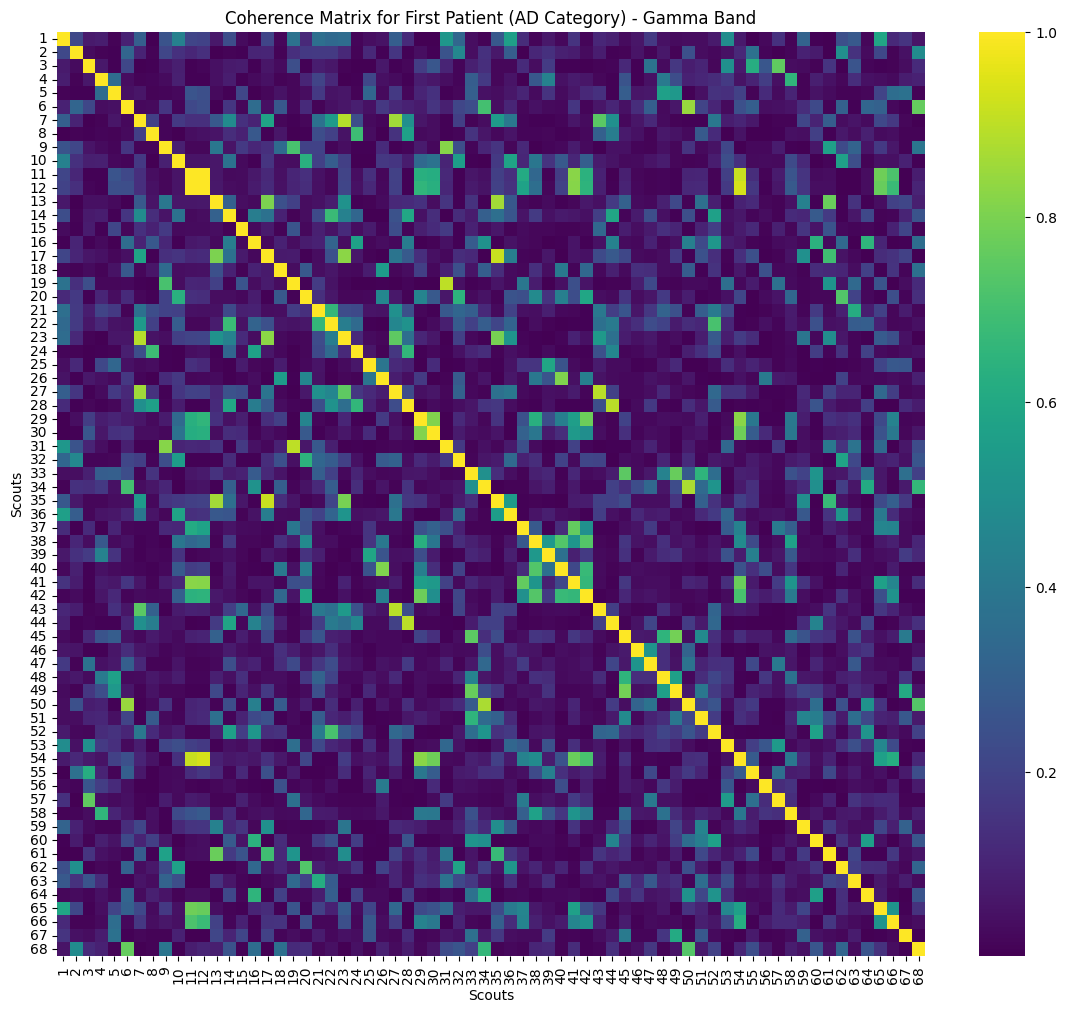

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize a single coherence matrix with labels from 1 to 68
def visualize_matrix(matrix, title):
    plt.figure(figsize=(14, 12))
    sns.heatmap(matrix, annot=False, cmap='viridis', xticklabels=range(1, 69), yticklabels=range(1, 69))
    plt.title(title)
    plt.xlabel('Scouts')
    plt.ylabel('Scouts')
    plt.show()

# Extract the coherence matrix for the first patient in the AZ category
single_patient_az_matrix = coherence_AZ_rebuilt[:, :, 4, 0]  # Choosing the first frequency band (index 0)

# Visualize the coherence matrix for the first patient in the AZ category
visualize_matrix(single_patient_az_matrix, 'Coherence Matrix for First Patient (AD Category) - Gamma Band')


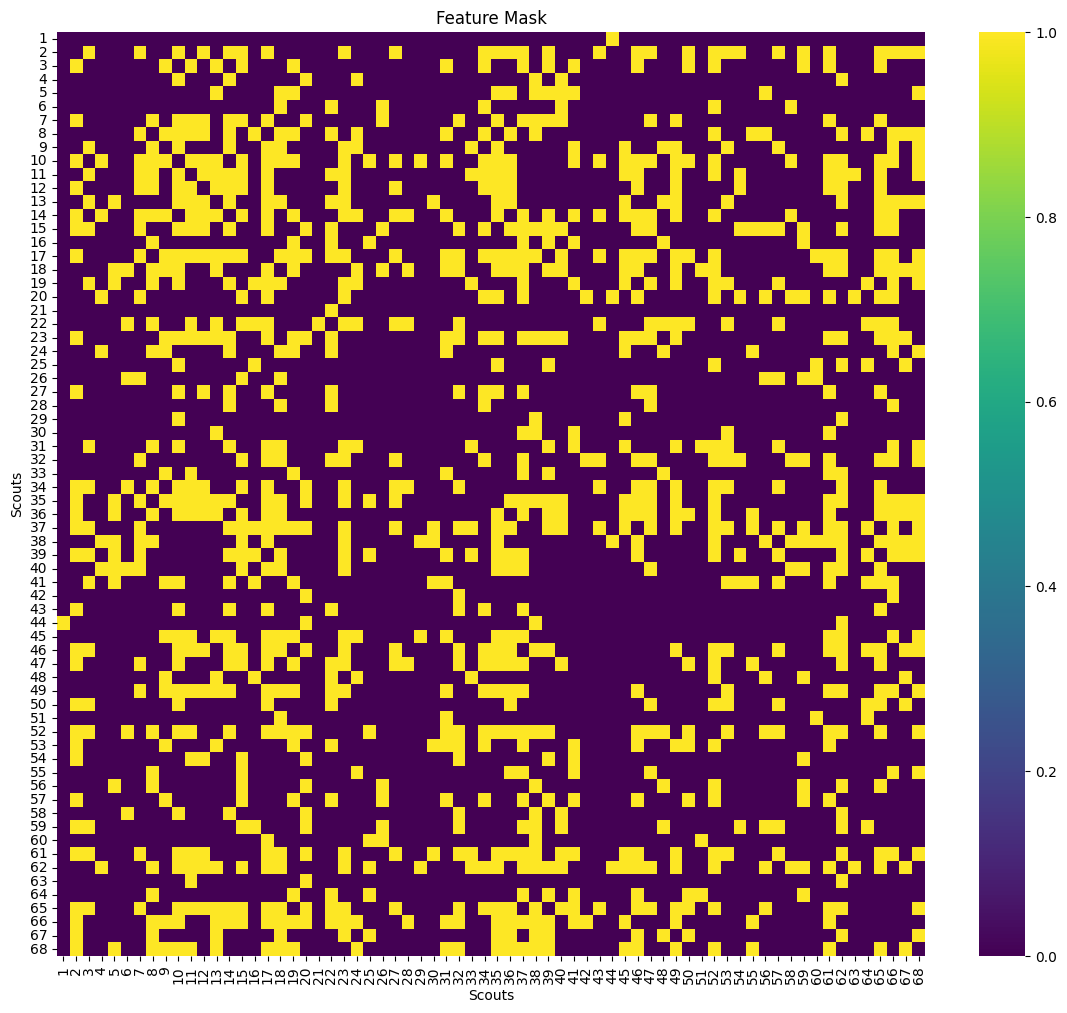

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize a single coherence matrix with labels from 1 to 68
def visualize_matrix(matrix, title):
    plt.figure(figsize=(14, 12))
    sns.heatmap(matrix, annot=False, cmap='viridis', xticklabels=range(1, 69), yticklabels=range(1, 69))
    plt.title(title)
    plt.xlabel('Scouts')
    plt.ylabel('Scouts')
    plt.show()

# Extract the mask matrix
combined_mask_matrix = combined_mask_rebuilt[:, :, 2, 0]  # Choosing the third feature (index 2) and first frequency band (index 0)

# Visualize the combined feature mask matrix
visualize_matrix(combined_mask_matrix, 'Feature Mask')


Extracts edge features from the coherence matrices and assigns labels to them. The function iterates over the subjects and bands, extracting the upper triangular part of each coherence matrix (excluding the diagonal). These edge attributes are then stored in a feature array, and the corresponding labels are stored in a label array

In [ ]:
def extract_edge_features_labels(data, label):
    features = []
    labels = []

    # Iterate over each sample
    for i in range(data.shape[3]):  # Samples dimension (36)
        combined_edge_attr = []

        # Iterate over each frequency band
        for j in range(data.shape[2]):  # Frequency bands dimension (5)
            matrix = data[:, :, j, i]  # Extract the 68x68 matrix for the j-th frequency band and i-th sample
            edge_attr = matrix[np.triu_indices_from(matrix, k=1)]  # Extract upper triangular part (excluding diagonal)
            combined_edge_attr.extend(edge_attr)  # Combine features from all frequency bands

        features.append(combined_edge_attr)  # Append combined features for the current sample
        labels.append(label)  # Append the label for the current sample

    return np.array(features), np.array(labels)

Use the `extract_edge_features_labels` function to extract features and labels for different classification tasks:
1. Alzheimer's Disease (AZ) vs. Healthy Controls (HC)
2. Frontotemporal Dementia (FTD) vs. Healthy Controls (HC)
3. Frontotemporal Dementia (FTD) vs. Alzheimer's Disease (AZ)

For each classification task, extract the edge features and labels from the rebuilt coherence matrices and concatenate them to form the complete dataset for each classification task

In [ ]:
# Extract features and labels for AZ vs HC
features_az_hc, labels_az_hc = extract_edge_features_labels(coherence_HC_rebuilt, 0)
features_az_hc_, labels_az_hc_ = extract_edge_features_labels(coherence_AZ_rebuilt, 2)
features_az_hc = np.concatenate((features_az_hc, features_az_hc_), axis=0)
labels_az_hc = np.concatenate((labels_az_hc, labels_az_hc_), axis=0)

# Extract features and labels for FTD vs HC
features_ftd_hc, labels_ftd_hc = extract_edge_features_labels(coherence_HC_rebuilt, 0)
features_ftd_hc_, labels_ftd_hc_ = extract_edge_features_labels(coherence_FTD_rebuilt, 1)
features_ftd_hc = np.concatenate((features_ftd_hc, features_ftd_hc_), axis=0)
labels_ftd_hc = np.concatenate((labels_ftd_hc, labels_ftd_hc_), axis=0)

# Extract features and labels for FTD vs AZ
features_ftd_az, labels_ftd_az = extract_edge_features_labels(coherence_FTD_rebuilt, 1)
features_ftd_az_, labels_ftd_az_ = extract_edge_features_labels(coherence_AZ_rebuilt, 2)
features_ftd_az = np.concatenate((features_ftd_az, features_ftd_az_), axis=0)
labels_ftd_az = np.concatenate((labels_ftd_az, labels_ftd_az_), axis=0)

Mask

In [ ]:
# Extract mask features and mask labels for AZ vs HC
combined_features_masks, labels_mask_az_hc = extract_edge_features_labels(combined_mask_rebuilt, 7)
combined_features_masks = combined_features_masks.astype(bool)

Feature summary

In [ ]:
print(features_az_hc)
print(features_az_hc.shape)
print(features_ftd_hc)
print(features_ftd_hc.shape)
print(features_ftd_az)
print(features_ftd_az.shape)

print(combined_features_masks)
print(combined_features_masks.shape)


# Count the number of True values
count_combined_mask = np.sum(combined_features_masks)
print("Number of True values in combined mask:", count_combined_mask)


[[0.0064655 0.011165  0.014464  ... 0.019189  0.49542   0.0089861]
 [0.038783  0.0094551 0.029784  ... 0.039615  0.60515   0.013265 ]
 [0.015197  0.026829  0.0057344 ... 0.064488  0.57968   0.027768 ]
 ...
 [0.019476  0.096817  0.018929  ... 0.26105   0.30483   0.0099666]
 [0.0046354 0.14496   0.015572  ... 0.0031334 0.80269   0.0046541]
 [0.050195  0.34734   0.048097  ... 0.033842  0.25913   0.0034092]]
(65, 11390)
[[0.0064655 0.011165  0.014464  ... 0.019189  0.49542   0.0089861]
 [0.038783  0.0094551 0.029784  ... 0.039615  0.60515   0.013265 ]
 [0.015197  0.026829  0.0057344 ... 0.064488  0.57968   0.027768 ]
 ...
 [0.043877  0.17554   0.17839   ... 0.068158  0.60366   0.0038902]
 [0.0020666 0.16073   0.0020763 ... 0.10793   0.50309   0.012232 ]
 [0.017157  0.0087877 0.0015265 ... 0.0052457 0.55556   0.0056814]]
(52, 11390)
[[0.017369  0.1525    0.0035784 ... 0.012836  0.16951   0.01831  ]
 [0.062365  0.0016943 0.011352  ... 0.0021896 0.83835   0.0027147]
 [0.028775  0.0050539 0.01

Feature masking and selecting

In [ ]:

combined_feature_mask_flat = combined_features_masks.flatten()
print(combined_feature_mask_flat)
print(combined_feature_mask_flat.shape)

# Apply the mask to extract only the selected features
masked_features_az_hc = features_az_hc[:, combined_feature_mask_flat]
masked_features_ftd_hc = features_ftd_hc[:, combined_feature_mask_flat]
masked_features_ftd_az = features_ftd_az[:, combined_feature_mask_flat]

print("Original AZ_HC features shape:", features_az_hc.shape)
print("Mask AZ_HC shape:", combined_feature_mask_flat.shape)
print("Masked AZ_HC features shape:", masked_features_az_hc.shape)

print("Original FTD_HC features shape:", features_ftd_hc.shape)
print("Mask FTD_HC shape:", combined_feature_mask_flat.shape)
print("Masked FTD_HC features shape:", masked_features_ftd_hc.shape)

print("Original FTD_AZ features shape:", features_ftd_az.shape)
print("Mask FTD_AZ shape:", combined_feature_mask_flat.shape)
print("Masked FTD_AZ features shape:", masked_features_ftd_az.shape)


[False  True False ... False False  True]
(11390,)
Original AZ_HC features shape: (65, 11390)
Mask AZ_HC shape: (11390,)
Masked AZ_HC features shape: (65, 1966)
Original FTD_HC features shape: (52, 11390)
Mask FTD_HC shape: (11390,)
Masked FTD_HC features shape: (52, 1966)
Original FTD_AZ features shape: (59, 11390)
Mask FTD_AZ shape: (11390,)
Masked FTD_AZ features shape: (59, 1966)


Visualize the edge features of a coherence matrix. The function takes the features, label, and title as inputs and plots the edge features using Matplotlib anlog with the labels

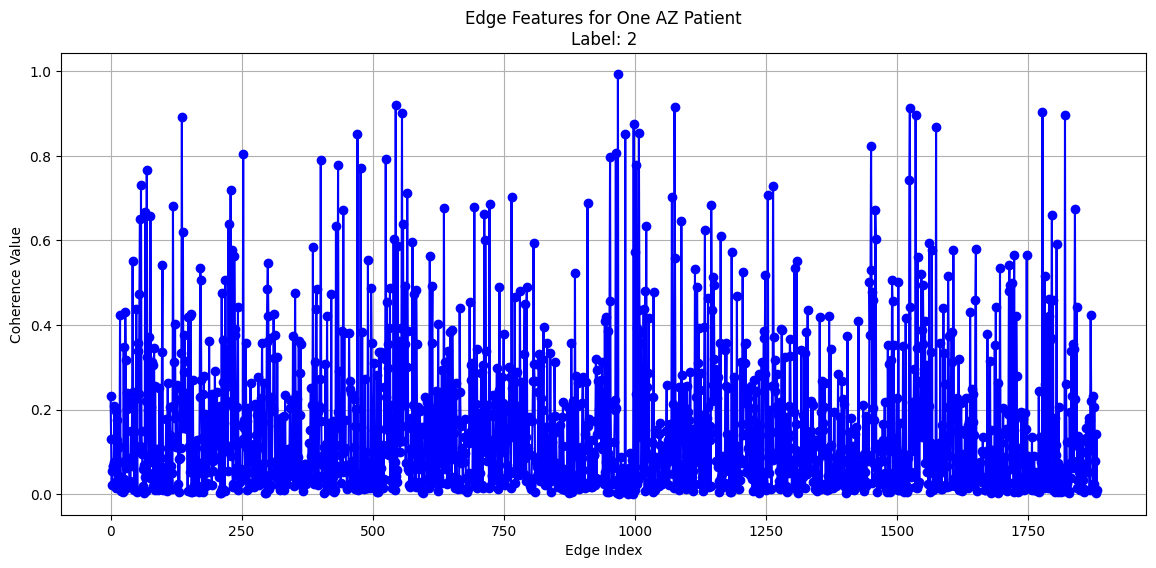

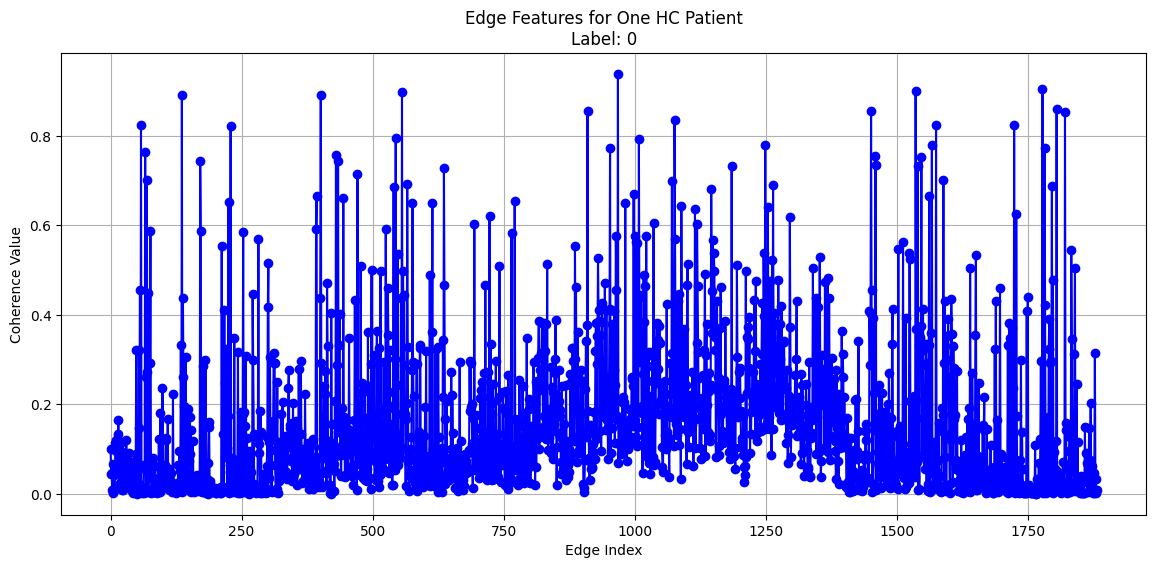

In [ ]:
# Function to visualize the edge features
def visualize_features(features, label, title):
    plt.figure(figsize=(14, 6))
    plt.plot(features, marker='o', linestyle='-', color='b')
    plt.title(f"{title}\nLabel: {label}")
    plt.xlabel('Edge Index')
    plt.ylabel('Coherence Value')
    plt.grid(True)
    plt.show()

# Extracting features and label for one patient from AZ and one from HC
az_patient_index = np.where(labels_az_hc == 2)[0][0]  # Index of the first AZ patient
hc_patient_index = np.where(labels_az_hc == 0)[0][0]  # Index of the first HC patient

az_patient_features = masked_features_az_hc[az_patient_index]
hc_patient_features =  masked_features_az_hc[hc_patient_index]

az_patient_label = labels_az_hc[az_patient_index]
hc_patient_label = labels_az_hc[hc_patient_index]

# Visualize the features for one AZ patient
visualize_features(az_patient_features, az_patient_label, 'Edge Features for One AZ Patient')

# Visualize the features for one HC patient
visualize_features(hc_patient_features, hc_patient_label, 'Edge Features for One HC Patient')

Split the extracted features and labels into training and testing sets for three classification tasks:
1. Alzheimer's Disease (AZ) vs. Healthy Controls (HC)
2. Frontotemporal Dementia (FTD) vs. Healthy Controls (HC)
3. Frontotemporal Dementia (FTD) vs. Alzheimer's Disease (AZ)

In [ ]:
# Split data into training and testing sets for AZ vs HC
X_train_az_hc, X_test_az_hc, y_train_az_hc, y_test_az_hc = train_test_split(masked_features_az_hc, labels_az_hc, test_size=0.2, random_state=42)

# Split data into training and testing sets for FTD vs HC
X_train_ftd_hc, X_test_ftd_hc, y_train_ftd_hc, y_test_ftd_hc = train_test_split(masked_features_ftd_hc, labels_ftd_hc, test_size=0.2, random_state=42)

# Split data into training and testing sets for FTD vs AZ
X_train_ftd_az, X_test_ftd_az, y_train_ftd_az, y_test_ftd_az = train_test_split(masked_features_ftd_az, labels_ftd_az, test_size=0.2, random_state=42)


In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning using Optuna for SVC (AZ vs HC)
def objective_svc_az_hc(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel != 'linear' else 'scale'

    svc = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, probability=True)
    scores = cross_val_score(svc, X_train_az_hc, y_train_az_hc, cv=10)
    return scores.mean()

study_svc_az_hc = optuna.create_study(direction='maximize')
study_svc_az_hc.optimize(objective_svc_az_hc, n_trials=500)

best_params_svc_az_hc = study_svc_az_hc.best_params
print("Best parameters for SVC (AZ vs HC):", best_params_svc_az_hc)

svc_best_az_hc = SVC(**best_params_svc_az_hc)
svc_best_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = svc_best_az_hc.predict(X_test_az_hc)
print("Classification Report for SVC (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for SVC (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for SVC (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))


[I 2024-08-09 18:16:42,688] A new study created in memory with name: no-name-5fe2af23-7ae7-4455-8710-9978f28e5a92
<ipython-input-53-2fb5c0cdfab9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2024-08-09 18:16:42,803] Trial 0 finished with value: 0.5399999999999999 and parameters: {'C': 0.011881453985034792, 'kernel': 'poly', 'degree': 5, 'gamma': 'auto'}. Best is trial 0 with value: 0.5399999999999999.
<ipython-input-53-2fb5c0cdfab9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2024-08-09 18:16:42,894] Trial 1 finished with value: 0.5599999999999999 and parameters: {'C

Best parameters for SVC (AZ vs HC): {'C': 0.08417824373866711, 'kernel': 'linear'}
Classification Report for SVC (AZ vs HC):
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           2       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13

Confusion Matrix for SVC (AZ vs HC):
[[4 1]
 [1 7]]
Accuracy for SVC (AZ vs HC): 0.8461538461538461


In [ ]:
# Hyperparameter tuning using Optuna for SVC (FTD vs HC)
def objective_svc_ftd_hc(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel != 'linear' else 'scale'

    svc = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, probability=True)
    scores = cross_val_score(svc, X_train_ftd_hc, y_train_ftd_hc, cv=10)
    return scores.mean()

study_svc_ftd_hc = optuna.create_study(direction='maximize')
study_svc_ftd_hc.optimize(objective_svc_ftd_hc, n_trials=500)

best_params_svc_ftd_hc = study_svc_ftd_hc.best_params
print("Best parameters for SVC (FTD vs HC):", best_params_svc_ftd_hc)

svc_best_ftd_hc = SVC(**best_params_svc_ftd_hc)
svc_best_ftd_hc.fit(X_train_ftd_hc, y_train_ftd_hc)
y_pred_ftd_hc = svc_best_ftd_hc.predict(X_test_ftd_hc)
print("Classification Report for SVC (FTD vs HC):")
print(classification_report(y_test_ftd_hc, y_pred_ftd_hc))
print("Confusion Matrix for SVC (FTD vs HC):")
print(confusion_matrix(y_test_ftd_hc, y_pred_ftd_hc))
print("Accuracy for SVC (FTD vs HC):", accuracy_score(y_test_ftd_hc, y_pred_ftd_hc))


[I 2024-08-09 18:19:18,548] A new study created in memory with name: no-name-c20fe626-5186-4a36-8c32-d5e039da4282
<ipython-input-54-d04af3b1c739>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2024-08-09 18:19:18,672] Trial 0 finished with value: 0.8300000000000001 and parameters: {'C': 26.700955017788118, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.8300000000000001.
<ipython-input-54-d04af3b1c739>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2024-08-09 18:19:18,775] Trial 1 finished with value: 0.5599999999999999 and parameters: {'C': 0.00653629878

Best parameters for SVC (FTD vs HC): {'C': 1.6953850458743818, 'kernel': 'rbf', 'gamma': 'scale'}
Classification Report for SVC (FTD vs HC):
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.80      0.89         5

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11

Confusion Matrix for SVC (FTD vs HC):
[[6 0]
 [1 4]]
Accuracy for SVC (FTD vs HC): 0.9090909090909091


In [ ]:
# Hyperparameter tuning using Optuna for SVC (AZ vs FTD)
def objective_svc_ftd_az(trial):
    C = trial.suggest_loguniform('C', 1e-1, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

    svc = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
    scores = cross_val_score(svc, X_train_ftd_az, y_train_ftd_az, cv=10)
    return scores.mean()

study_svc_ftd_az = optuna.create_study(direction='maximize')
study_svc_ftd_az.optimize(objective_svc_ftd_az, n_trials=1000)

best_params_svc_ftd_az = study_svc_ftd_az.best_params
print("Best parameters for SVC (AZ vs FTD):", best_params_svc_ftd_az)

svc_best_ftd_az = SVC(**best_params_svc_ftd_az)
svc_best_ftd_az.fit(X_train_ftd_az, y_train_ftd_az)
y_pred_ftd_az = svc_best_ftd_az.predict(X_test_ftd_az)
print("Classification Report for SVC (AZ vs FTD):")
print(classification_report(y_test_ftd_az, y_pred_ftd_az))
print("Confusion Matrix for SVC (AZ vs FTD):")
print(confusion_matrix(y_test_ftd_az, y_pred_ftd_az))
print("Accuracy for SVC (AZ vs FTD):", accuracy_score(y_test_ftd_az, y_pred_ftd_az))


Streaming output truncated to the last 5000 lines.
<ipython-input-51-56cab91677ac>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-1, 1e3)
<ipython-input-51-56cab91677ac>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
[I 2024-08-09 17:57:06,497] Trial 0 finished with value: 0.6100000000000001 and parameters: {'C': 34.37810136527973, 'gamma': 0.011340751839871535, 'kernel': 'linear'}. Best is trial 0 with value: 0.6100000000000001.
<ipython-input-51-56cab91677ac>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:

Best parameters for SVC (AZ vs FTD): {'C': 256.2063292041088, 'gamma': 0.01425320509380262, 'kernel': 'sigmoid'}
Classification Report for SVC (AZ vs FTD):
              precision    recall  f1-score   support

           1       0.71      1.00      0.83         5
           2       1.00      0.71      0.83         7

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.83        12
weighted avg       0.88      0.83      0.83        12

Confusion Matrix for SVC (AZ vs FTD):
[[5 0]
 [2 5]]
Accuracy for SVC (AZ vs FTD): 0.8333333333333334


Classification Reports for 3 Models

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the SVC models with the provided parameters

# svc_az_hc = SVC(C=2.1214906873874253, gamma=0.004484292508881285, kernel='rbf', probability=True)
# {'C': 0.11270661472823854, 'gamma': 0.16554604989987254, 'kernel': 'poly'}
# {'C': 0.08417824373866711, 'kernel': 'linear'}
svc_az_hc = SVC(C=0.08417824373866711, kernel='linear', probability=True)


# svc_ftd_hc = SVC(C=4.052602921806768, gamma=0.0042184837966682395, kernel='rbf', probability=True)
# {'C': 0.03208690181351073, 'gamma': 0.18157193875483335, 'kernel': 'linear'}
#  {'C': 1.6953850458743818, 'kernel': 'rbf', 'gamma': 'scale'}
svc_ftd_hc = SVC(C= 1.6953850458743818, gamma='scale', kernel='rbf', probability=True)


# svc_ftd_az = SVC(C=218.092808835883, kernel='sigmoid', gamma='scale', probability=True)

# {'C': 233.74681216558378, 'kernel': 'sigmoid', 'gamma': 'scale'}
# {'C': 256.2063292041088, 'gamma': 0.01425320509380262, 'kernel': 'sigmoid'}
# {'C': 264.97543383155426, 'kernel': 'sigmoid', 'gamma': 'scale'}
svc_ftd_az = SVC(C=256.2063292041088, kernel='sigmoid', gamma= 0.01425320509380262, probability=True)

# Define datasets for each comparison in the desired order
datasets = {
    'AZ_vs_HC': (X_train_az_hc, y_train_az_hc, X_test_az_hc, y_test_az_hc),
    'FTD_vs_HC': (X_train_ftd_hc, y_train_ftd_hc, X_test_ftd_hc, y_test_ftd_hc),
    'AZ_vs_FTD': (X_train_ftd_az, y_train_ftd_az, X_test_ftd_az, y_test_ftd_az)
}

# Define the classifiers dictionary in the desired order
classifiers = {
    'AZ_vs_HC': svc_az_hc,
    'FTD_vs_HC': svc_ftd_hc,
    'AZ_vs_FTD': svc_ftd_az
}

# Initialize a dictionary to store the cross-validation results
cv_results = {}

# Loop through each comparison and perform cross-validation
for comparison, clf in classifiers.items():
    X_train, y_train, X_test, y_test = datasets[comparison]

    # Perform cross-validation and store the results
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    cv_results[comparison] = scores

    # Evaluate the SVC model on the test set
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Print results for each model
    print(f"\nSummary of cross-validation results for {comparison}:")
    print(f"{comparison}: Mean accuracy = {scores.mean():.4f}, Standard deviation = {scores.std():.4f}")

    print(f"\nClassification Report for {comparison}:")
    print(classification_report(y_test, y_pred))

    print(f"Confusion Matrix for {comparison}:")
    print(confusion_matrix(y_test, y_pred))

    print(f"Accuracy for {comparison}: {accuracy_score(y_test, y_pred):.4f}")



Summary of cross-validation results for AZ_vs_HC:
AZ_vs_HC: Mean accuracy = 0.8900, Standard deviation = 0.1174

Classification Report for AZ_vs_HC:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           2       1.00      0.88      0.93         8

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13

Confusion Matrix for AZ_vs_HC:
[[5 0]
 [1 7]]
Accuracy for AZ_vs_HC: 0.9231

Summary of cross-validation results for FTD_vs_HC:
FTD_vs_HC: Mean accuracy = 0.8300, Standard deviation = 0.1122

Classification Report for FTD_vs_HC:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.80      0.89         5

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.9

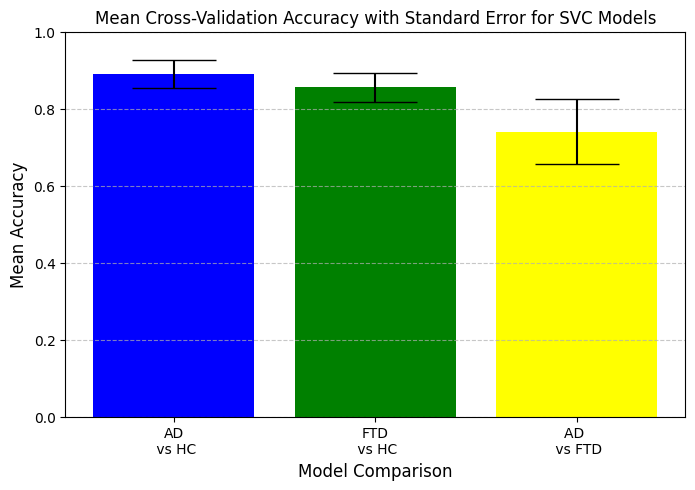

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ["AD\n vs HC",
          'FTD\n vs HC',
          "AD \n vs FTD"]
mean_accuracies = [0.8900, 0.8550, 0.7400]
sem_values = [0.0371, 0.0377, 0.0851]

# Create a bar plot with error bars (Standard Error)
plt.figure(figsize=(8, 5))
bars = plt.bar(models, mean_accuracies, yerr=sem_values, capsize=30, color=['blue', 'green', 'yellow'])

# Add labels and title
plt.xlabel('Model Comparison', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.title('Mean Cross-Validation Accuracy with Standard Error for SVC Models', fontsize=12)

# Set the y-axis limits
plt.ylim(0, 1)

# Rotate x-axis labels for better readability and center them
plt.xticks(rotation=0, ha='center')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


Training SVC models for AZ vs HC,FTD vs HC and AZ vs FTD using the best parameters obtained

In [ ]:

# 'SVC': SVC(C=2.1214906873874253,gamma=0.004484292508881285,kernel='rbf',probability=True)
# SVC(C=0.08417824373866711, kernel='linear', probability=True)
svc_az_hc = SVC(C=0.08417824373866711, kernel='linear', probability=True)
svc_az_hc.fit(X_train_az_hc, y_train_az_hc)


#{'C': 218.092808835883, 'kernel': 'sigmoid', 'gamma': 'scale'}
# SVC(C=256.2063292041088, kernel='sigmoid', gamma= 0.01425320509380262, probability=True)
svc_ftd_az = SVC(C=256.2063292041088, kernel='sigmoid', gamma= 0.01425320509380262, probability=True)
svc_ftd_az.fit(X_train_ftd_az, y_train_ftd_az)

# 'SVC'= SVC(C=4.115770269418699,gamma=0.003852086974868314,kernel='poly',probability=True)
#(C= 1.6953850458743818, gamma='scale', kernel='rbf', probability=True)
svc_ftd_hc = SVC(C= 1.6953850458743818, gamma='scale', kernel='rbf', probability=True)
svc_ftd_hc.fit(X_train_ftd_hc, y_train_ftd_hc)




SVC(C=1.6953850458743818, probability=True)

Combined model

In [ ]:
def combined_model(X):
    predictions = []
    for x in X:
        x = x.reshape(1, -1)
        pred_az_hc = svc_az_hc.predict(x)
        pred_ftd_hc = svc_ftd_hc.predict(x)
        if pred_az_hc == 0 and pred_ftd_hc == 0:
            predictions.append(0)  # Healthy Control
        else:
            pred_ftd_az = svc_ftd_az.predict(x)
            if pred_ftd_az == 1:
                predictions.append(1)  # FTD
            else:
                predictions.append(2)  # AZ
    return np.array(predictions)

In [ ]:
# Combine test sets and labels for final evaluation
X_test_combined = np.concatenate((X_test_az_hc, X_test_ftd_hc, X_test_ftd_az), axis=0)
y_test_combined = np.concatenate((y_test_az_hc, y_test_ftd_hc, y_test_ftd_az), axis=0)

# Predict using the combined model
y_pred_combined = combined_model(X_test_combined)

Classification Report for Combined Model

In [ ]:
print("Classification Report for Combined Model:")
print(classification_report(y_test_combined, y_pred_combined))
print("Confusion Matrix for Combined Model:")
print(confusion_matrix(y_test_combined, y_pred_combined))
print("Accuracy for Combined Model:", accuracy_score(y_test_combined, y_pred_combined))

Classification Report for Combined Model:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.75      0.90      0.82        10
           2       1.00      0.67      0.80        15

    accuracy                           0.81        36
   macro avg       0.82      0.83      0.81        36
weighted avg       0.84      0.81      0.81        36

Confusion Matrix for Combined Model:
[[10  1  0]
 [ 1  9  0]
 [ 3  2 10]]
Accuracy for Combined Model: 0.8055555555555556


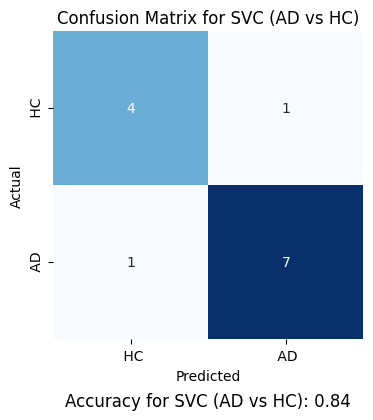

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix data
conf_matrix = np.array([[4, 1], [1, 7]])
accuracy = 0.84  # Accuracy value

# Create a heatmap using seaborn
plt.figure(figsize=(4 , 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[' HC', ' AD'],
            yticklabels=[' HC', ' AD'])

# Add labels and title
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for SVC (AD vs HC)')

# Display accuracy below the heatmap
plt.text(0.5, -0.2, f'Accuracy for SVC (AD vs HC): {accuracy:.2f}',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

# Show the plot
plt.show()


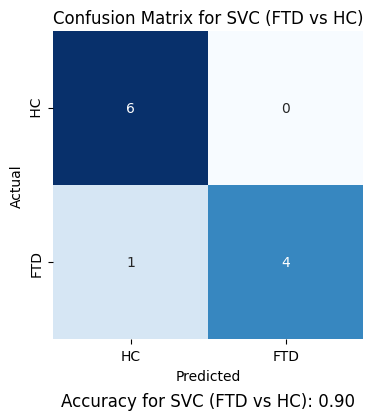

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix data
conf_matrix = np.array([[6, 0], [1, 4]])
accuracy = 0.90  # Accuracy value

# Create a heatmap using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['HC', 'FTD'],
            yticklabels=[' HC', 'FTD'])

# Add labels and title
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for SVC (FTD vs HC)')

# Display accuracy below the heatmap
plt.text(0.5, -0.2, f'Accuracy for SVC (FTD vs HC): {accuracy:.2f}',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

# Show the plot
plt.show()


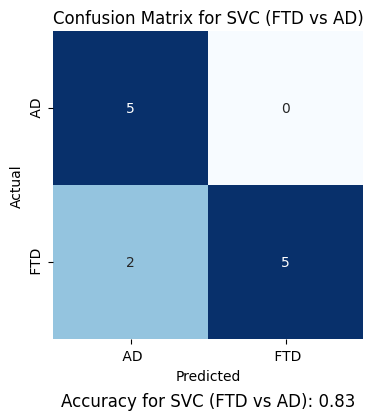

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#[[3 2] [3 4]]
#[[5 0] [2 5]]

# Confusion matrix data
conf_matrix = np.array([[5, 0], [2, 5]])
accuracy = 0.83  # Accuracy value

# Create a heatmap using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[' AD', ' FTD'],
            yticklabels=[' AD', ' FTD'])

# Add labels and title
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for SVC (FTD vs AD)')

# Display accuracy below the heatmap
plt.text(0.5, -0.2, f'Accuracy for SVC (FTD vs AD): {accuracy:.2f}',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

# Show the plot
plt.show()


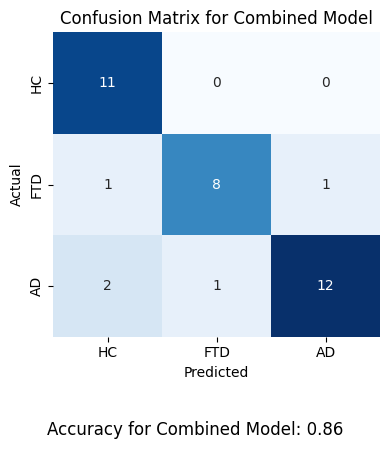

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# [[11 0 0] [ 1 0 9] [ 3 0 12]]
# [[11  0  0] [ 1  5  4] [ 3  3  9]]
# [[11 0 0] [ 1 8 1] [ 4 2 9]]
# [[11 0 0] [ 1 8 1] [ 2 1 12]]
# Confusion matrix data
conf_matrix = np.array([[11, 0, 0],
                        [ 1, 8, 1],
                        [ 2, 1, 12]])

# Class labels
class_labels = ['HC', 'FTD', 'AD']

# Create a heatmap using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Combined Model')

# Add accuracy text below the plot
accuracy = 0.86
plt.figtext(0.5, -0.1, f'Accuracy for Combined Model: {accuracy:.2f}', ha='center', fontsize=12)

# Adjust layout to ensure the accuracy text is visible
plt.tight_layout()

# Show the plot
plt.show()
